# I. Algorithm

Once again, we will use sckitlearn's built in Random Forest classifier.

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score

from mpl_toolkits.mplot3d import Axes3D


# II. Application to Data Set

Next, we'll create a plot of Rating Average vs. Complexity Average for kid games and teen games.

I'll apply a Random Forest classifier to the coaster data.

In [73]:
coaster_data = pd.read_csv("../coaster_db.csv")

coaster_subset = coaster_data[['height_ft','speed_mph','Inversions_clean','Gforce_clean']]

clean_data = coaster_subset.dropna()

# Creating column for whether coaster has at least one inversion or not

clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)

/var/folders/xh/x976_5p93059y1sn4ybh8ql40000gn/T/ipykernel_21182/1071987350.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['Inverted'] = clean_data['Inversions_clean'].apply(lambda x: 1 if x > 0 else 0)


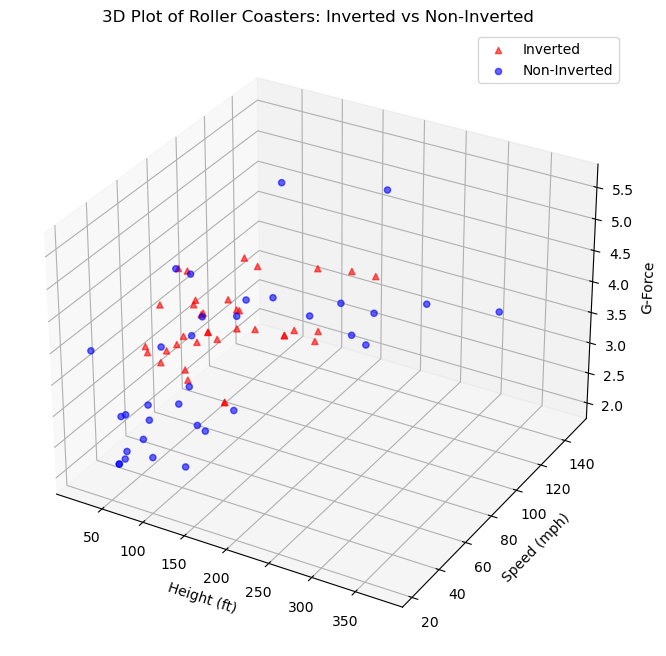

In [83]:
# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Separate data based on inversion status
inverted_data = clean_data[clean_data['Inverted'] == 1]  # Data where Inverted = 1
non_inverted_data = clean_data[clean_data['Inverted'] == 0]  # Data where Inverted = 0

# Scatter plot for inverted rides
ax.scatter(inverted_data['height_ft'], inverted_data['speed_mph'], inverted_data['Gforce_clean'], 
           c='r', marker='^', label='Inverted', alpha=0.6)

# Scatter plot for non-inverted rides
ax.scatter(non_inverted_data['height_ft'], non_inverted_data['speed_mph'], non_inverted_data['Gforce_clean'], 
           c='b', marker='o', label='Non-Inverted', alpha=0.6)

# Add labels and title
ax.set_xlabel('Height (ft)')
ax.set_ylabel('Speed (mph)')
ax.set_zlabel('G-Force')
ax.set_title('3D Plot of Roller Coasters: Inverted vs Non-Inverted')

# Add legend
ax.legend()

# Show the plot

In [81]:
# Preparing data 
X = clean_data[['height_ft', 'speed_mph','Gforce_clean']]
y = clean_data['Inverted']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Decision Tree Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=10, max_depth=15)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 3)}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.929

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.80      0.89         5
           1       0.90      1.00      0.95         9

    accuracy                           0.93        14
   macro avg       0.95      0.90      0.92        14
weighted avg       0.94      0.93      0.93        14



The accuracy has increased significantly to 93%! Now, let's plot a ROC curve. The ROC curve illustrates the trade off between precision and recall. Precision refers to the proportion of cases detected positive that are actually positive. Recall refers to the proportion of actual positive cases that are detected positive. 

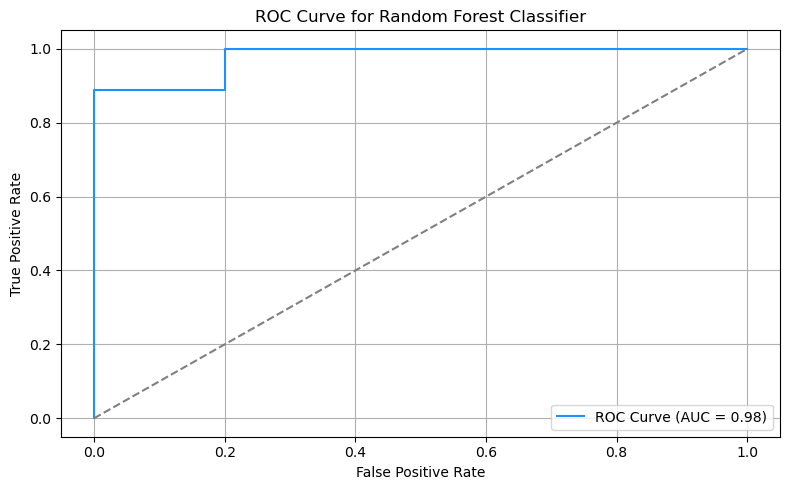

In [78]:
# Get predicted probabilities for the positive class (Inverted = 1)
y_probs = clf.predict_proba(X_test)[:, 1]  # probability for class 1

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute AUC (Area Under Curve)
auc_score = roc_auc_score(y_test, y_probs)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(fpr, tpr, color='dodgerblue', label=f"ROC Curve (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Random Forest Classifier')
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.show()

The greater the area of the curve, the better the model. The dashed-line illustrates a classifer that randomly classifies things to one category with a 50% chance and the other category with a 50% chance. We can see that our model is pretty successful. Now, let's look at feature importance.

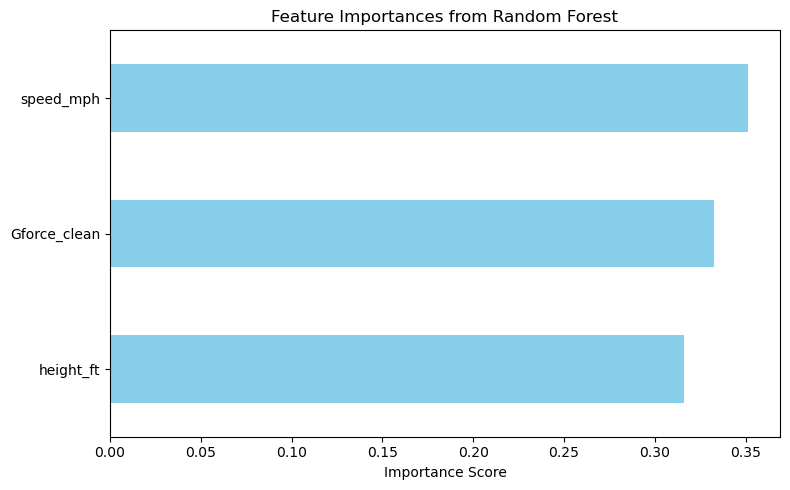

In [75]:
# Get feature importances
importances = clf.feature_importances_
feature_names = X.columns

# Create a DataFrame
feat_importances = pd.Series(importances, index=feature_names)
feat_importances = feat_importances.sort_values(ascending=True)

# Plot
plt.figure(figsize=(8, 5))
feat_importances.plot(kind='barh', color='skyblue')
plt.title('Feature Importances from Random Forest')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()

Feature importance is calculated based on the "impurity reduction" in each of the individual decision trees. In each tree, the forest makes splits based on the amount of entropy that is reduced. For each feature, the algorithm tracks how much that feature contributes to decreasing entropy across all trees. These contributions are averaged and normlized to get the importance score.

In this case, we can see that all 3 features have roughly the same importance score, with ```'speed_mph'``` narrowly leading. This makes sense looking the scatter plot, where we can see that most non-inverted roller coasters reach a much slower speed. We can look at the histograms to see the distributions.

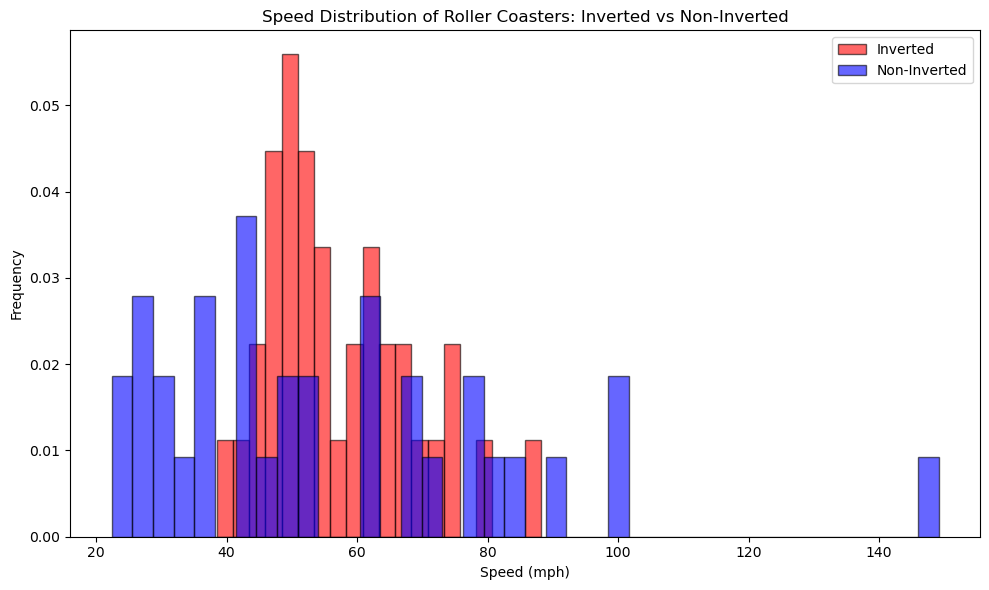

In [90]:
# Separate the data based on inversion status
inverted_speeds = inverted_data['speed_mph'] # Speeds for inverted rides
non_inverted_speeds = non_inverted_data['speed_mph']  # Speeds for non-inverted rides

# Create the histogram plot
plt.figure(figsize=(10, 6))

# Plot histogram for inverted rides
plt.hist(inverted_speeds, bins=20, alpha=0.6, label='Inverted', color='r', edgecolor='black', density = True)

# Plot histogram for non-inverted rides
plt.hist(non_inverted_speeds, bins=40, alpha=0.6, label='Non-Inverted', color='b', edgecolor='black', density = True)

# Add labels and title
plt.xlabel('Speed (mph)')
plt.ylabel('Frequency')
plt.title('Speed Distribution of Roller Coasters: Inverted vs Non-Inverted')

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


Inverted roller coasters have a bimodal distribution with peaks around 50 mph and 65 mph. Non-inverted roller coasters are somewhat uniform in distribution with a couple outliers pulling the average to the right.